<a href="https://colab.research.google.com/github/imabari/rakuten_tools/blob/main/rakuten_ta_towercollector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
!pip install pyproj

In [3]:
import pandas as pd
import pyproj

In [4]:
import matplotlib.pyplot as plt
from sklearn import linear_model

In [ ]:
df0 = pd.read_csv(fn, parse_dates=["measured_at"]).dropna(how="all", axis=1)
df0

In [6]:
# 日時変換
df0["measured_at"] = df0["measured_at"].dt.tz_convert("Asia/Tokyo").dt.tz_localize(None)

In [ ]:
# バンド指定
df1 = df0.query("mcc == 440 & mnc == 11 & net_type == 'LTE'").copy()
df1

In [8]:
df1.columns

Index(['mcc', 'mnc', 'lac', 'cell_id', 'short_cell_id', 'rnc', 'psc', 'asu',
       'dbm', 'ta', 'lat', 'lon', 'accuracy', 'speed', 'bearing', 'altitude',
       'measured_at', 'net_type', 'neighboring', 'device', 'rsrp', 'rsrq',
       'rssi', 'rssnr', 'arfcn'],
      dtype='object')

In [9]:
df1.dropna(subset=["ta"], inplace=True)
df1["ta"] = df1["ta"].astype(int)
df1.sort_values(["cell_id", "ta", "dbm"], ascending=[True, True, False], inplace=True)

In [10]:
df1.drop_duplicates(subset=["cell_id", "ta"], inplace=True)

In [11]:
df1["ta"].unique()

array([ 2,  3,  4,  1,  5,  6, 33,  0,  7,  9, 10, 15, 11,  8, 38, 39, 27,
       28, 29])

In [12]:
df1["id"] = df1["short_cell_id"].astype(str) + "-" + df1["rnc"].astype(str)

In [ ]:
df1

In [14]:
def enblcid_split(df0):

    df0["eNB-LCID"] = df0["eNB-LCID"].str.split()
    df1 = df0.explode("eNB-LCID")

    df1[["eNB", "LCID"]] = df1["eNB-LCID"].str.split("-", expand=True)
    
    df1["LCID"] = df1["LCID"].str.split(",")
    df2 = df1.explode("LCID").astype({"eNB": int, "LCID": int})
    
    df3 = df2.sort_values(["eNB", "LCID"]).reset_index(drop=True)

    df3["id"] = df3["eNB"].astype(str) + "-" + df3["LCID"].astype(str)

    return df3

In [15]:
# スプレッドシートのURL
csv_url = "https://raku10ehime.github.io/map/ehime.csv"

In [ ]:
df2 = pd.read_csv(csv_url, index_col=0).dropna(how="all").dropna(subset=["eNB-LCID"])
df2

In [ ]:
df3 = enblcid_split(df2).sort_values(by=["eNB", "LCID"]).loc[:, ["id", "場所", "緯度", "経度"]]
df3

In [ ]:
df4 = pd.merge(df1, df3, on="id")
df4

In [19]:
grs80 = pyproj.Geod(ellps="GRS80")

In [20]:
# 距離計算
df4["m"] = df4.apply(lambda x: grs80.inv(x["lon"], x["lat"], x["経度"], x["緯度"])[2], axis=1)

<Axes: xlabel='ta', ylabel='m'>

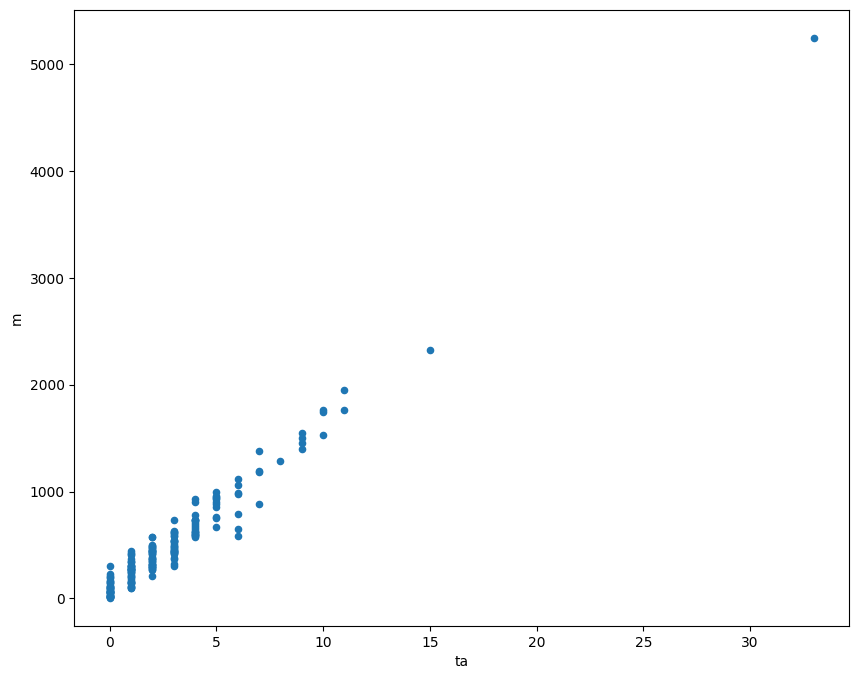

In [21]:
df4.plot.scatter(x="ta", y="m", figsize=(10, 8))

<Axes: xlabel='rsrp', ylabel='m'>

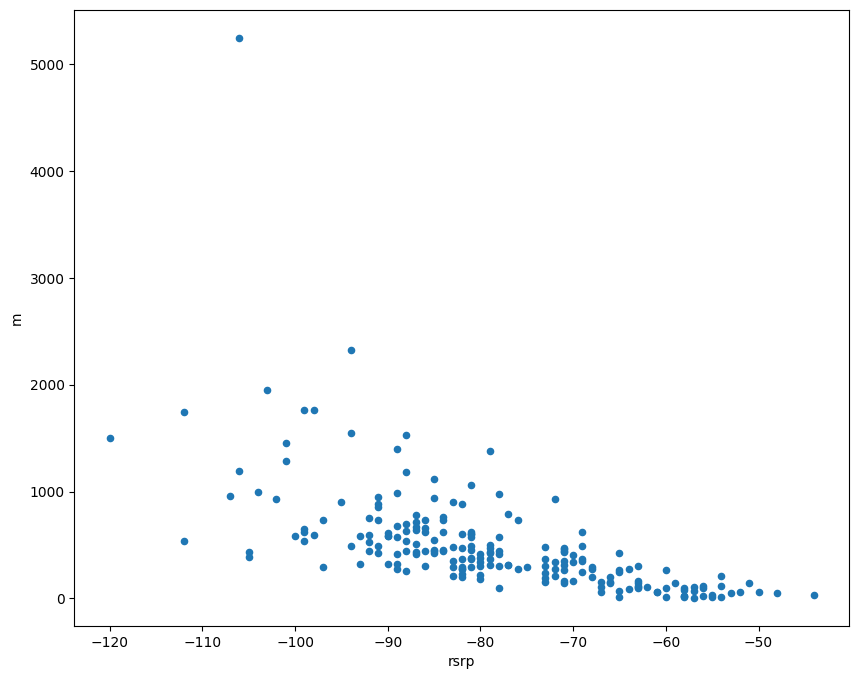

In [22]:
df4.plot.scatter(x="rsrp", y="m", figsize=(10, 8))

<Axes: >

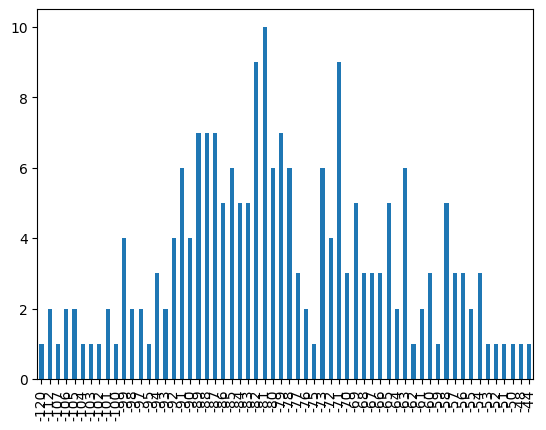

In [23]:
df4["rsrp"].value_counts().sort_index().plot.bar()

In [24]:
 def reg_plot(X, Y):
 
    clf = linear_model.LinearRegression()

    clf.fit(X, Y)

    # 散布図
    plt.scatter(X, Y)

    # 回帰直線
    plt.title("antenna")
    plt.plot(X, clf.predict(X), color="red")
    plt.xlabel("TA")
    plt.ylabel("m")
    plt.grid()
    plt.show()

    print(clf.coef_[0])

    return clf.coef_[0]

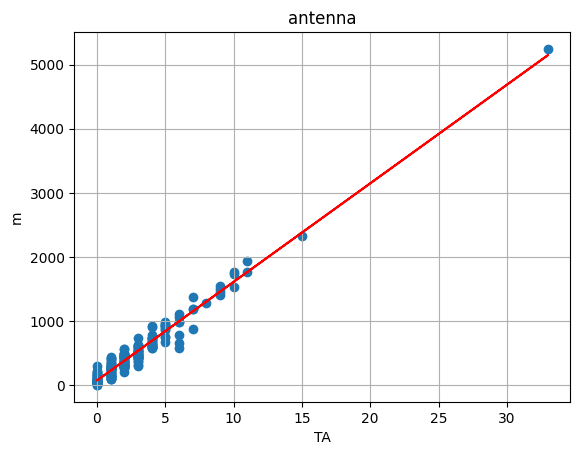

153.65583401293975


In [25]:
n = reg_plot(df4[["ta"]].values, df4["m"].values)